<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Auto_Credit_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Data Types:
ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation             

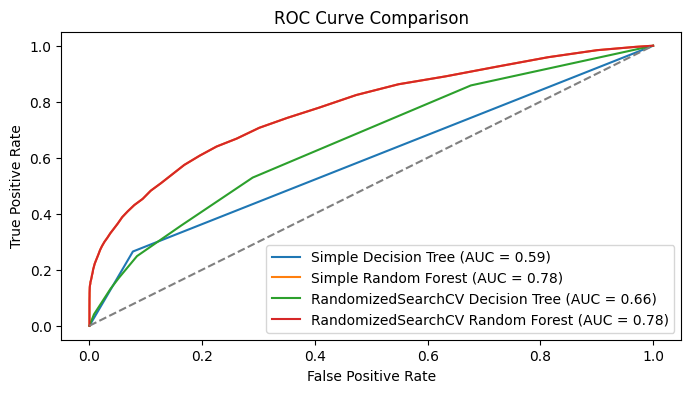

In [1]:
# ===========================================================
# Section 1: Import Libraries
# ===========================================================

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn preprocessing, feature engineering, and imputation
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# Scikit-learn model selection, classifiers, and ensemble methods
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

# Tabulate for displaying tables
from tabulate import tabulate

# ===========================================================
# Section 2: Load and Check Data for Errors
# ===========================================================

# Load the dataset
df = pd.read_csv('/content/AutoCredit.csv', low_memory=False)

# Check initial data types, missing values, duplicates, etc.
print("Initial Data Types:")
print(df.dtypes)
print("\nFirst 5 rows of data:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nCheck for duplicate rows:")
print(df.duplicated().sum())

# Display unique values in categorical columns
print("\nUnique values per column (for categorical columns):")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

# ===========================================================
# Section 3: Clean Data
# ===========================================================

# Define data types for specific columns and load the dataset
dtype_dict = {
    'ID': 'str', 'Client_Income': 'str', 'Credit_Amount': 'str', 'Loan_Annuity': 'str',
    'Accompany_Client': 'str', 'Client_Income_Type': 'str', 'Client_Education': 'str',
    'Client_Marital_Status': 'str', 'Client_Gender': 'str', 'Loan_Contract_Type': 'str',
    'Client_Housing_Type': 'str', 'Population_Region_Relative': 'str', 'Age_Days': 'str',
    'Employed_Days': 'str', 'Registration_Days': 'str', 'ID_Days': 'str', 'Client_Occupation': 'str',
    'Client_Permanent_Match_Tag': 'str', 'Client_Contact_Work_Tag': 'str', 'Type_Organization': 'str',
    'Score_Source_3': 'str'
}
df = pd.read_csv('AutoCredit.csv', dtype=dtype_dict, low_memory=False)

# Clean non-numeric columns
def clean_numeric_columns(df):
    numeric_columns = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Age_Days',
                       'Employed_Days', 'Registration_Days', 'ID_Days']
    for column in numeric_columns:
        if df[column].dtype == 'object':
            df[column] = df[column].replace({r'\$': '', ',': ''}, regex=True)
            df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

df = clean_numeric_columns(df)

# Map certain categories to reduce unique values
def map_columns(df):
    df["Client_Income_Type"] = df["Client_Income_Type"].replace({
        "Transport: type 1": "Others", "Industry: type 10 ": "Others", "Industry: type 6": "Others",
        "Religion": "Others", "Industry: type 13": "Others", "Trade: type 4": "Others", "Industry: type 8": "Others",
        "Student": "other", "Unemployed": "other", "Maternity leave": "other", "Businessman": "other"
    })
    df["Client_Education"] = df["Client_Education"].replace({"Post Grad": "Graduate"})
    df["Accompany_Client"] = df["Accompany_Client"].replace({"##": "Others", "Group": "Others"})
    return df

df = map_columns(df)

# Fill missing values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df.drop(columns=df[numeric_cols].columns[df[numeric_cols].isnull().all()], inplace=True)
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Label encode non-numeric columns
def label_encode_columns(df):
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

df = label_encode_columns(df)

# ===========================================================
# Section 4: Preprocessing and Feature Engineering
# ===========================================================

# Create dummy variables for categorical features
X = pd.get_dummies(df.drop('Default', axis=1), drop_first=True)
y = df['Default']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===========================================================
# Section 5: Model Training and Evaluation
# ===========================================================

# Simple Decision Tree
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train_scaled, y_train)
y_prob_dt_basic = dt_basic.predict_proba(X_test_scaled)[:, 1]
roc_auc_dt_basic = roc_auc_score(y_test, y_prob_dt_basic)
fpr_dt_basic, tpr_dt_basic, _ = roc_curve(y_test, y_prob_dt_basic)

# Simple Random Forest
rf_basic = RandomForestClassifier(random_state=42)
rf_basic.fit(X_train_scaled, y_train)
y_prob_rf_basic = rf_basic.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf_basic = roc_auc_score(y_test, y_prob_rf_basic)
fpr_rf_basic, tpr_rf_basic, _ = roc_curve(y_test, y_prob_rf_basic)

# RandomizedSearchCV Decision Tree
param_dist_dt = {
    'max_depth': [3, 5, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]
}
random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                                      param_distributions=param_dist_dt,
                                      n_iter=5, cv=3, random_state=42, n_jobs=-1)
random_search_dt.fit(X_train_scaled, y_train)
y_prob_dt_random = random_search_dt.best_estimator_.predict_proba(X_test_scaled)[:, 1]
roc_auc_dt_random = roc_auc_score(y_test, y_prob_dt_random)
fpr_dt_random, tpr_dt_random, _ = roc_curve(y_test, y_prob_dt_random)

# RandomizedSearchCV Random Forest
param_dist_rf = {
    'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=5, cv=3, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_scaled, y_train)
y_prob_rf_random = random_search_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf_random = roc_auc_score(y_test, y_prob_rf_random)
fpr_rf_random, tpr_rf_random, _ = roc_curve(y_test, y_prob_rf_random)

# ===========================================================
# Section 6: Model Comparison
# ===========================================================

# Model comparison data table
model_comparison_data = [
    ["Simple Decision Tree", dt_basic.score(X_test_scaled, y_test), roc_auc_dt_basic],
    ["Simple Random Forest", rf_basic.score(X_test_scaled, y_test), roc_auc_rf_basic],
    ["RandomizedSearchCV Decision Tree", random_search_dt.best_estimator_.score(X_test_scaled, y_test), roc_auc_dt_random],
    ["RandomizedSearchCV Random Forest", random_search_rf.best_estimator_.score(X_test_scaled, y_test), roc_auc_rf_random]
]

print("\nModel Comparisons:")
print(tabulate(model_comparison_data, headers=["Model", "Accuracy", "ROC AUC Score"], tablefmt="grid", floatfmt=".4f"))

# ===========================================================
# Section 7: ROC Curve Plot
# ===========================================================

plt.figure(figsize=(8, 4))
plt.plot(fpr_dt_basic, tpr_dt_basic, label=f'Simple Decision Tree (AUC = {roc_auc_dt_basic:.2f})')
plt.plot(fpr_rf_basic, tpr_rf_basic, label=f'Simple Random Forest (AUC = {roc_auc_rf_basic:.2f})')
plt.plot(fpr_dt_random, tpr_dt_random, label=f'RandomizedSearchCV Decision Tree (AUC = {roc_auc_dt_random:.2f})')
plt.plot(fpr_rf_random, tpr_rf_random, label=f'RandomizedSearchCV Random Forest (AUC = {roc_auc_rf_random:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
